# Introduction

This sample dataset is from the course of Fast Five Campus. The dataset contains sales data with order date, ship date, shipping area, product, quantity, and amount, etc. The goal is finding any improvement points and creating the model to forecast the next 1 year sales volume.

## Data Cleaning

### Import Library

Import any necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime as dt
from prophet import Prophet
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split as tts 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

### Import Raw data

In [2]:
sales = pd.read_excel(r"C:\Users\HWLEE\Desktop\study\Project data\sales\Superstore.xlsx")
returns = pd.read_excel(r"C:\Users\HWLEE\Desktop\study\Project data\sales\return data.xlsx")

print(sales.head())
print(returns.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [4]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  296 non-null    object
 1   Order ID  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


### Missing Data Check

In [5]:
total_m = sales.isnull().sum().sort_values(ascending=False)
percent = (sales.isnull().sum()/sales.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_m, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
Row ID,0,0.0
Postal Code,0,0.0
Discount,0,0.0
Quantity,0,0.0
Sales,0,0.0
Product Name,0,0.0
Sub-Category,0,0.0
Category,0,0.0
Product ID,0,0.0
Region,0,0.0


There is no missing data from sales dataset

In [6]:
total_m2 = returns.isnull().sum().sort_values(ascending=False)
percent2 = (returns.isnull().sum()/returns.isnull().count()).sort_values(ascending=False)
missing_data2 = pd.concat([total_m2, percent2], axis=1, keys=['Total Missing', 'Percent'])
missing_data2

,Total Missing,Percent
Returned,0,0.0
Order ID,0,0.0


There is no missing data from returns dataset

### Merge Return data with Sales Data

In [7]:
df = sales.merge(returns, how='left', on='Order ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

### add datetime columns

Add datetime columns to calculate any date related contents

In [8]:
df['dayofweek'] = df['Order Date'].dt.dayofweek
df['weekday'] = df['Order Date'].dt.day_name()
df['quarter'] = df['Order Date'].dt.quarter
df['month'] = df['Order Date'].dt.month
df['year'] = df['Order Date'].dt.year
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Returned,dayofweek,weekday,quarter,month,year
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,NaN,1,Tuesday,4,11,2016
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,NaN,1,Tuesday,4,11,2016
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,NaN,6,Sunday,2,6,2016
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,NaN,6,Sunday,4,10,2015
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,NaN,6,Sunday,4,10,2015


## Monthly/Weekday Trends

Remove "returned" orders to calculate sales amount without return

In [21]:
df[df['Returned'].isna()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Returned,dayofweek,weekday,quarter,month,year
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,NaN,1,Tuesday,4,11,2016
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,NaN,1,Tuesday,4,11,2016
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,NaN,6,Sunday,2,6,2016
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,NaN,6,Sunday,4,10,2015
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,NaN,6,Sunday,4,10,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,9987,CA-2016-125794,2016-09-29,2016-10-03,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,36.2400,1,0.00,15.2208,NaN,3,Thursday,3,9,2016
9987,9988,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,79.9900,1,0.00,28.7964,NaN,4,Friday,4,11,2017
9988,9989,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,206.1000,5,0.00,55.6470,NaN,4,Friday,4,11,2017
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,25.2480,3,0.20,4.1028,NaN,1,Tuesday,1,1,2014


In [9]:
df_nort = df[df['Returned'].isna()]

## Monthly Trend

C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='Sales'>

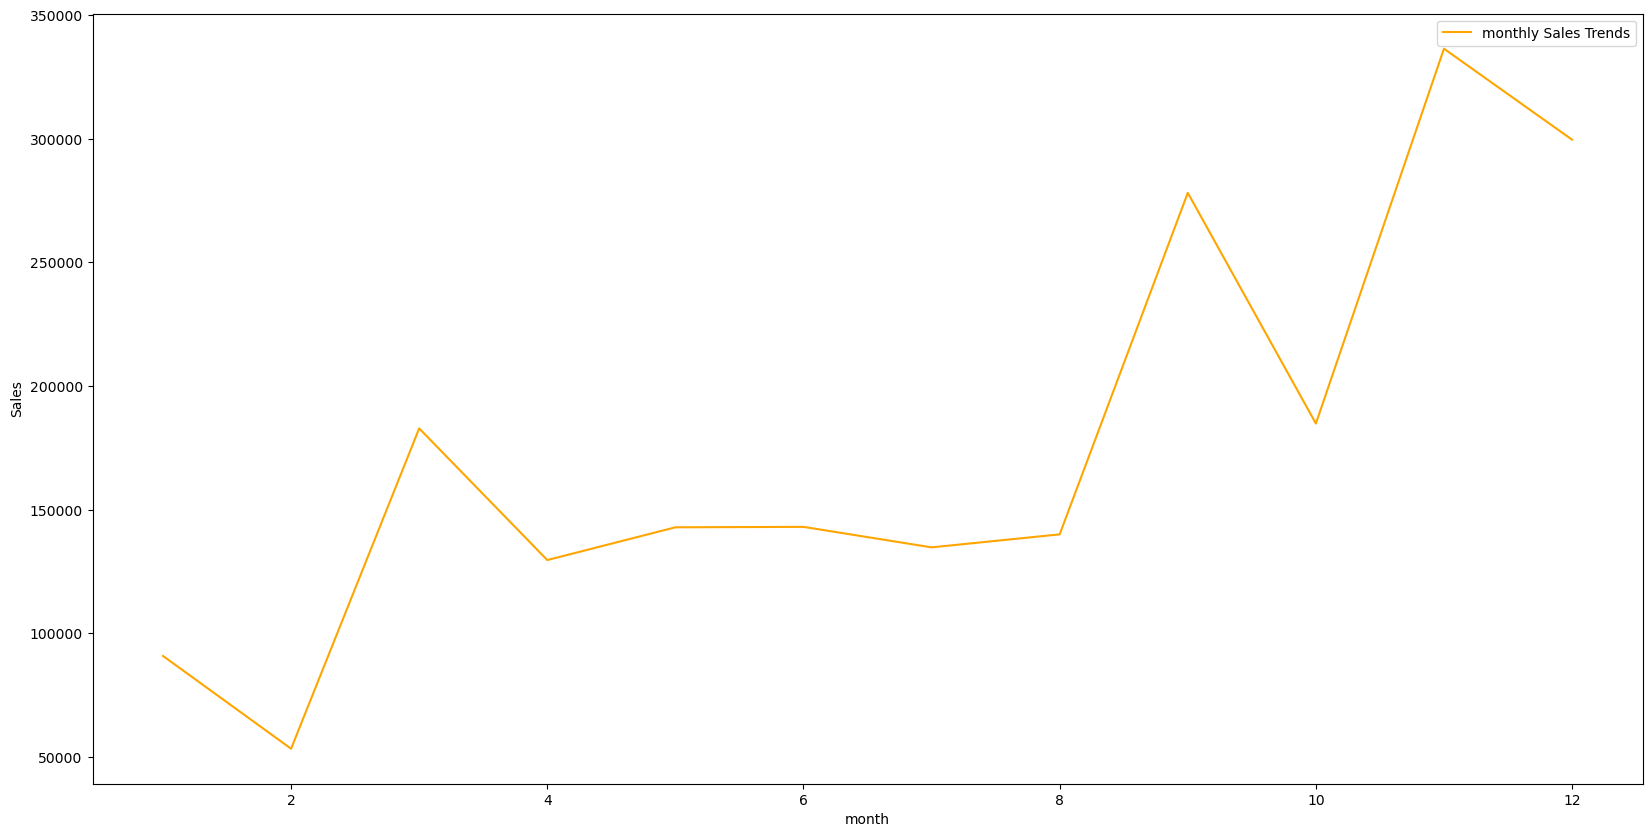

In [10]:
df_nort_gr1 = df_nort.groupby('month').agg({'Sales':'sum'})
plt.figure(figsize=(20, 10))
sns.lineplot(x="month", y="Sales", data=df_nort_gr1, color='orange', label='monthly Sales Trends')

## Weekdays Trend

<Axes: title={'center': 'Weekdays Sales Trends'}, xlabel='Weekdays', ylabel='Total Sales'>

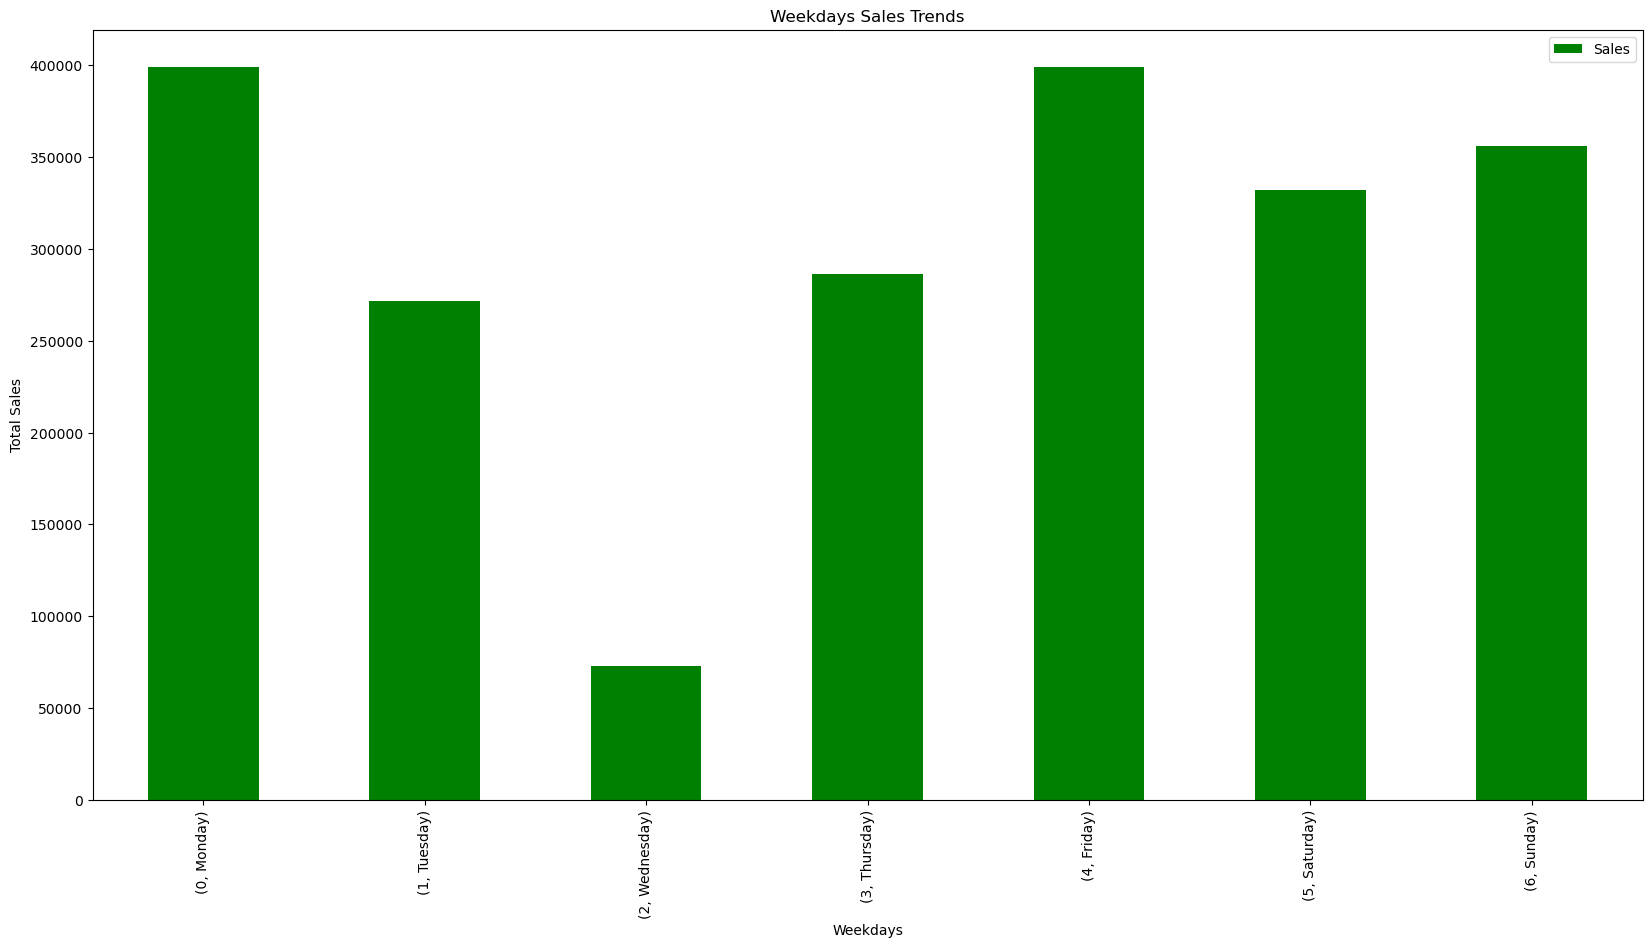

In [11]:
df_nort_gr = df_nort.groupby(['dayofweek', 'weekday']).agg({'Sales':'sum'})
df_nort_gr.plot.bar(
    title= 'Weekdays Sales Trends',
    ylabel= 'Total Sales',
    xlabel= 'Weekdays',
    color = 'green'
    ,figsize=(20, 10)
)

## Region, Product Analysis

The largest sales volume is in California while smallest sales volume is in North Dakota. I filtered these 2 cities and analyzed the difference.

In [16]:
state_data = df_nort[df_nort['State'].isin(['California', 'North Dakota'])]
state_data.groupby(['State',  'Category']).agg({'Sales': 'sum'}).reset_index()

,State,Category,Sales
0,California,Furniture,134452.063
1,California,Office Supplies,120852.086
2,California,Technology,137465.794
3,North Dakota,Office Supplies,919.910


In [14]:
ddd = df_nort[df_nort['State'].isin(['California'])]
ddd.groupby([  'Category','year','month']).agg({'Sales': 'sum'}).sort_values('Sales')

Sales
Category        year month            
Furniture       2014 2        129.5680
Office Supplies 2014 2        179.1340
                2015 2        194.8500
                2014 6        218.0640
Technology      2017 6        247.7660
...                                ...
Furniture       2016 11      8053.1660
                     12      8571.8820
                2014 12      9017.1705
Technology      2016 6       9275.9860
Office Supplies 2014 7      10376.3760

[141 rows x 1 columns]

In [13]:
ddd = df_nort[df_nort['State'].isin(['North Dakota'])]
ddd.groupby([  'Category','year','month']).agg({'Sales': 'sum'}).sort_values('Sales')

Sales
Category        year month        
Office Supplies 2017 12      28.38
                     5      891.53

Only 2017 data is available for the North Dakota region, whereas California has data covering numerous transactions since 2014.

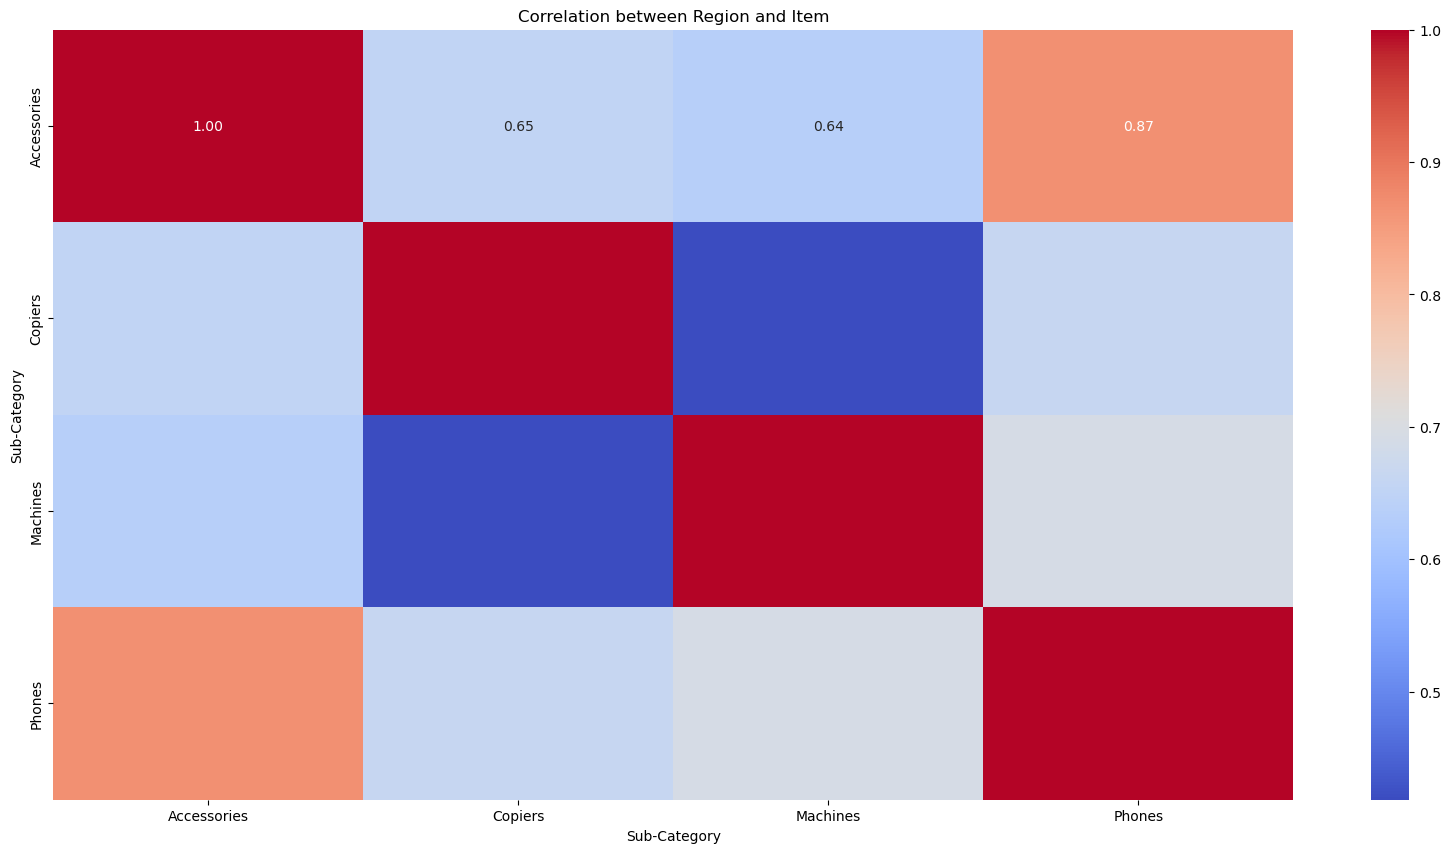

In [22]:
pivot_table = df_nort[df_nort['Category'].isin(['Technology'])]
pivot_table = pivot_table.pivot_table(values='Sales', index='City', columns='Sub-Category', aggfunc='sum', fill_value=0)

correlation = pivot_table.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Region and Item')
plt.show()

*2H Sales increased compared to 1H*

*Wednesday has significantly low sales volume*
- Need marketing or promotion to increase the volume

To increase North Dakota Region Sales:
- No order history in 2014 - 2016, customers in North Dakota started buying product in May 2017
    - Advertising needed to the customers in North Dakota
- Only Home office products were sold
    - Need to start selling Furniture and Techonology to North Dakota to increase the Sales

*Accessories and Phones has high correlation (0.87) which can be considered for marketing or promotion together*

*Supplies has low correlation with other sub-categories*

## Return Data Analysis

In [23]:
df['Returned'].value_counts()


Returned
Yes    800
Name: count, dtype: int64

I Filtered only 'Yes' data from Returned dataset

In [24]:
df_rt = df[df['Returned'] == 'Yes'] 
df_rt

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Returned,dayofweek,weekday,quarter,month,year
18,19,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,8.560,2,0.0,2.4824,Yes,2,Wednesday,3,8,2014
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,213.480,3,0.2,16.0110,Yes,2,Wednesday,3,8,2014
20,21,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,22.720,4,0.2,7.3840,Yes,2,Wednesday,3,8,2014
55,56,CA-2016-111682,2016-06-17,2016-06-18,First Class,TB-21055,Ted Butterfield,Consumer,United States,Troy,...,208.560,6,0.0,52.1400,Yes,4,Friday,2,6,2016
56,57,CA-2016-111682,2016-06-17,2016-06-18,First Class,TB-21055,Ted Butterfield,Consumer,United States,Troy,...,32.400,5,0.0,15.5520,Yes,4,Friday,2,6,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9957,9958,US-2014-143287,2014-11-11,2014-11-17,Standard Class,KN-16705,Kristina Nunn,Home Office,United States,New Rochelle,...,223.920,4,0.0,109.7208,Yes,1,Tuesday,4,11,2014
9958,9959,US-2014-143287,2014-11-11,2014-11-17,Standard Class,KN-16705,Kristina Nunn,Home Office,United States,New Rochelle,...,7.300,2,0.0,2.1900,Yes,1,Tuesday,4,11,2014
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,91.960,2,0.0,15.6332,Yes,6,Sunday,1,2,2017
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,258.576,2,0.2,19.3932,Yes,6,Sunday,1,2,2017


I grouped by 'order date' to see the daily trend

                Sales
Order Date           
2017-09-26      2.224
2017-09-10      2.780
2016-10-30      3.620
2014-08-22      3.912
2016-11-16      8.320
...               ...
2017-08-17   3397.732
2016-09-02   3658.489
2014-09-14   4283.792
2017-09-20   7359.918
2017-03-23  14052.480

[259 rows x 1 columns]


C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Order Date', ylabel='Sales'>

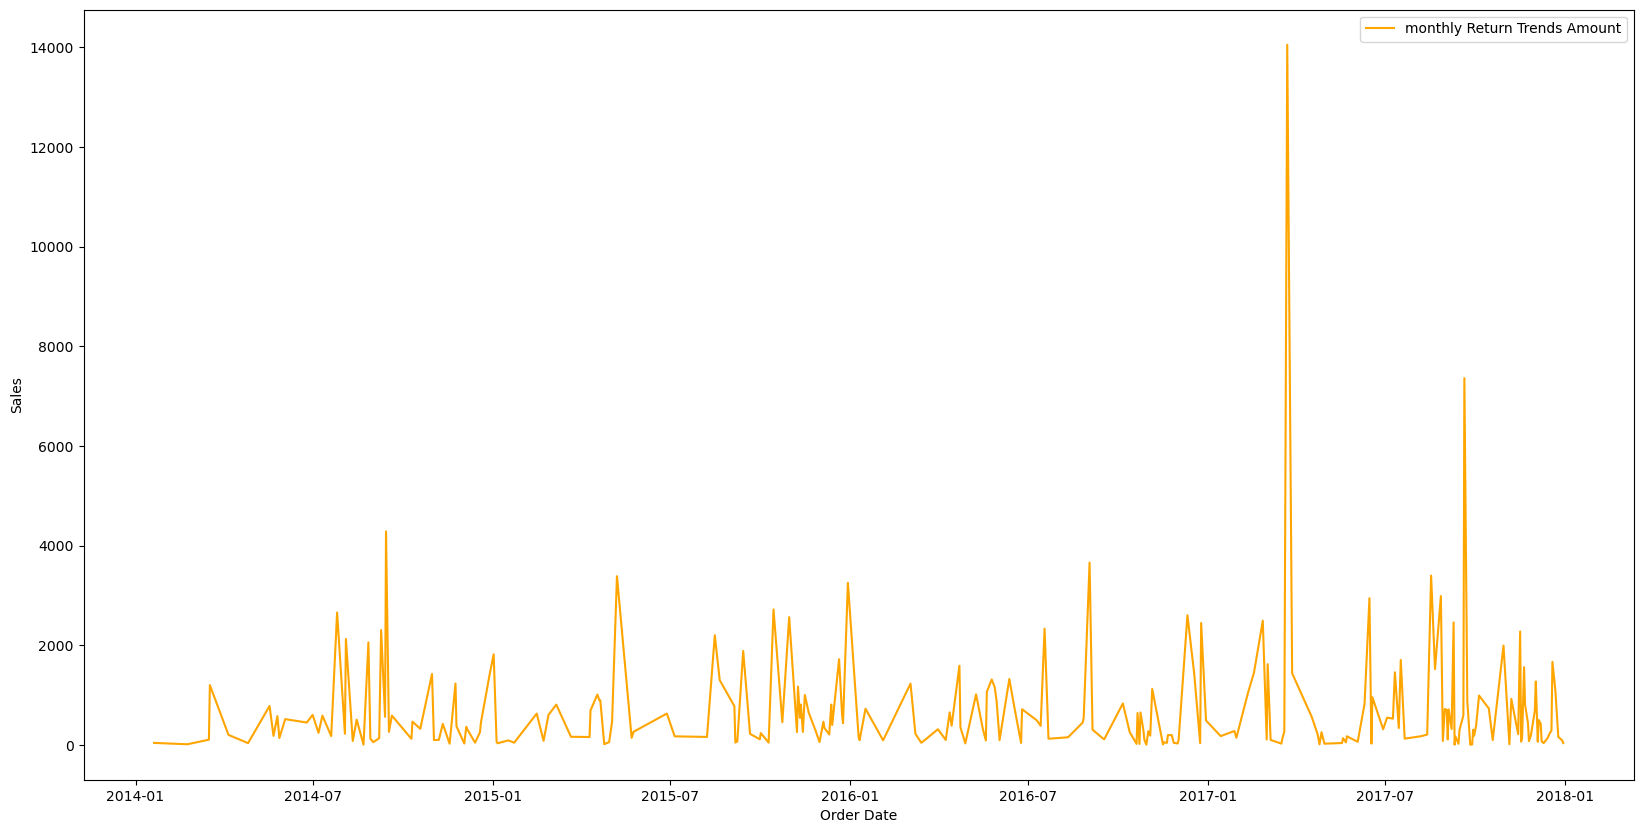

In [26]:
#sales amount
df_rt2 = df_rt.groupby('Order Date').agg({'Sales':'sum'})
print(df_rt2.sort_values('Sales'))
plt.figure(figsize=(20, 10))
sns.lineplot(x="Order Date", y="Sales", data=df_rt2, color='orange', label='monthly Return Trends Amount')


            Quantity
Order Date          
2015-01-05         1
2014-08-22         1
2016-10-27         1
2017-12-08         1
2017-09-10         1
...              ...
2014-12-29        40
2016-12-18        44
2017-09-20        52
2016-12-11        55
2016-09-02        58

[259 rows x 1 columns]


C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Order Date', ylabel='Quantity'>

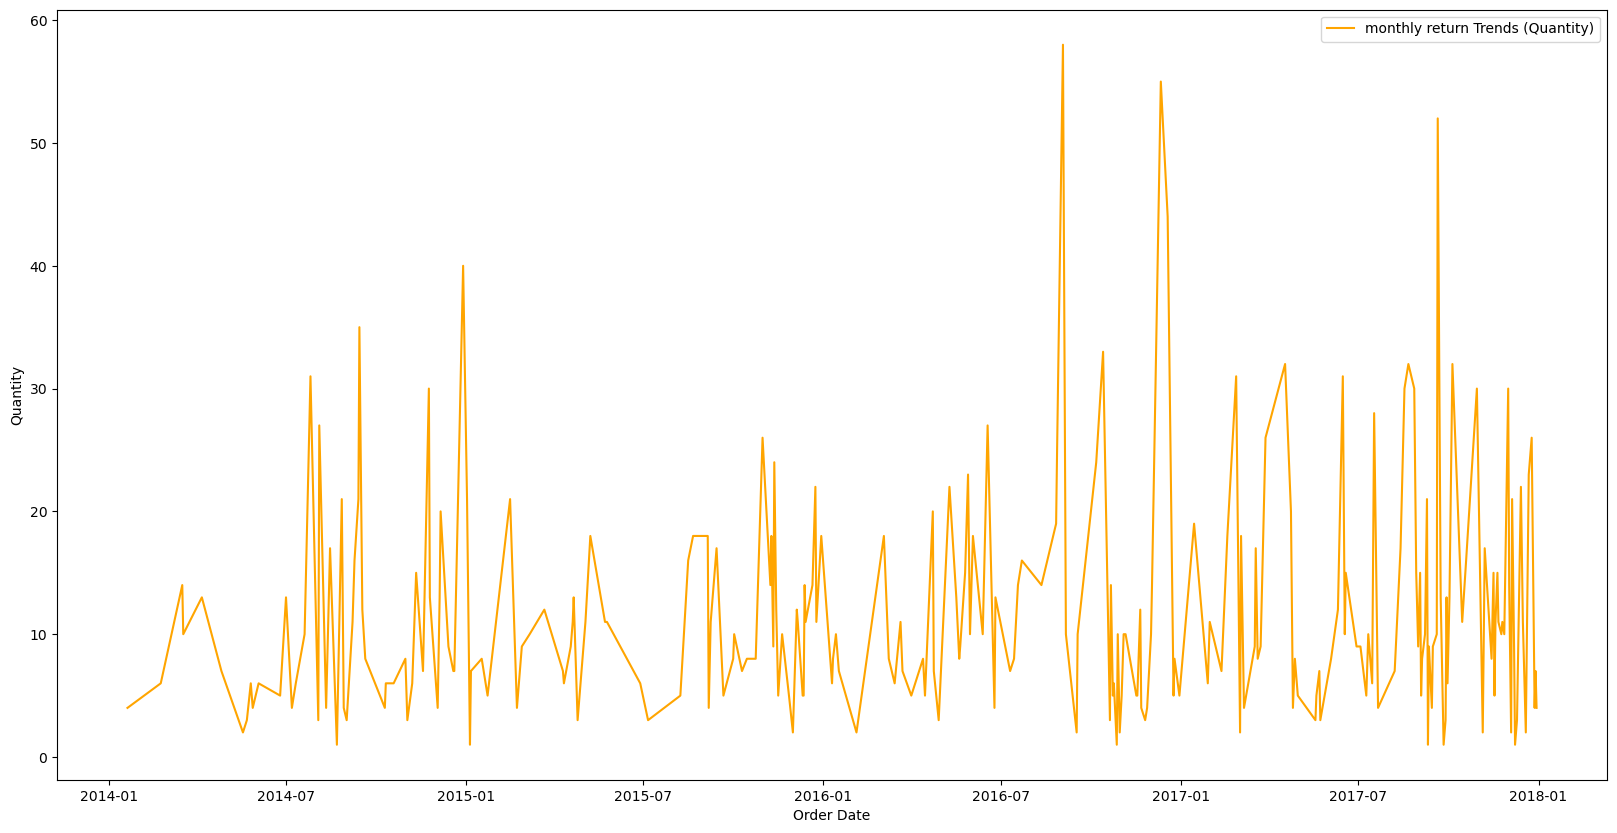

In [27]:
#sales quantity
df_rt3 = df_rt.groupby('Order Date').agg({'Quantity':'sum'})
print(df_rt3.sort_values('Quantity'))
plt.figure(figsize=(20, 10))
sns.lineplot(x="Order Date", y="Quantity", data=df_rt3, color='orange', label='monthly return Trends (Quantity)')

Since there is a peak on 2017 March 23rd, I checked the data on that date.

In [29]:
df_rt[df_rt['Order Date'] == '2017-03-23'] 

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Returned,dayofweek,weekday,quarter,month,year
8151,8152,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,32.48,2,0.0,4.8720,Yes,3,Thursday,1,3,2017
8152,8153,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,20.04,3,0.0,9.6192,Yes,3,Thursday,1,3,2017
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,13999.96,4,0.0,6719.9808,Yes,3,Thursday,1,3,2017


Only three products were returned, all by "Raymond Buch." This may indicate an issue with product quality or delivery, as he used the "First Class" shipping method. I reviewed his order history in detail, but no other returns were found.

In [30]:
df[df['Customer ID'] == 'RB-19360'] 

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Returned,dayofweek,weekday,quarter,month,year
447,448,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,59.520,3,0.0,15.4752,NaN,4,Friday,2,4,2016
448,449,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,161.940,3,0.0,9.7164,NaN,4,Friday,2,4,2016
449,450,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,263.880,6,0.0,71.2476,NaN,4,Friday,2,4,2016
450,451,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,30.480,3,0.0,7.9248,NaN,4,Friday,2,4,2016
451,452,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,9.840,3,0.0,2.8536,NaN,4,Friday,2,4,2016
452,453,CA-2016-166674,2016-04-01,2016-04-03,Second Class,RB-19360,Raymond Buch,Consumer,United States,Auburn,...,35.120,4,0.0,9.1312,NaN,4,Friday,2,4,2016
2855,2856,CA-2017-169810,2017-07-25,2017-07-31,Standard Class,RB-19360,Raymond Buch,Consumer,United States,Sioux Falls,...,20.230,7,0.0,9.5081,NaN,1,Tuesday,3,7,2017
3142,3143,CA-2017-162572,2017-09-25,2017-09-27,Second Class,RB-19360,Raymond Buch,Consumer,United States,Cincinnati,...,119.960,5,0.2,35.9880,NaN,0,Monday,3,9,2017
3143,3144,CA-2017-162572,2017-09-25,2017-09-27,Second Class,RB-19360,Raymond Buch,Consumer,United States,Cincinnati,...,10.608,6,0.2,0.9282,NaN,0,Monday,3,9,2017
3957,3958,CA-2016-156573,2016-05-29,2016-06-02,Standard Class,RB-19360,Raymond Buch,Consumer,United States,Nashville,...,11.277,3,0.7,-8.6457,NaN,6,Sunday,2,5,2016


### Return Rate Calculation

   Order Date  total_orders  total_returns  return_rate
0     2014-01           284              4     1.408451
1     2014-02           159              6     3.773585
2     2014-03           585             24     4.102564
3     2014-04           536             20     3.731343
4     2014-05           466             15     3.218884
5     2014-06           521             11     2.111324
6     2014-07           550             64    11.636364
7     2014-08           609             77    12.643678
8     2014-09          1000            106    10.600000
9     2014-10           573             24     4.188482
10    2014-11          1219             74     6.070550
11    2014-12          1079            100     9.267841
12    2015-01           236             42    17.796610
13    2015-02           239             34    14.225941
14    2015-03           515             22     4.271845
15    2015-04           543             57    10.497238
16    2015-05           575             51     8

C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


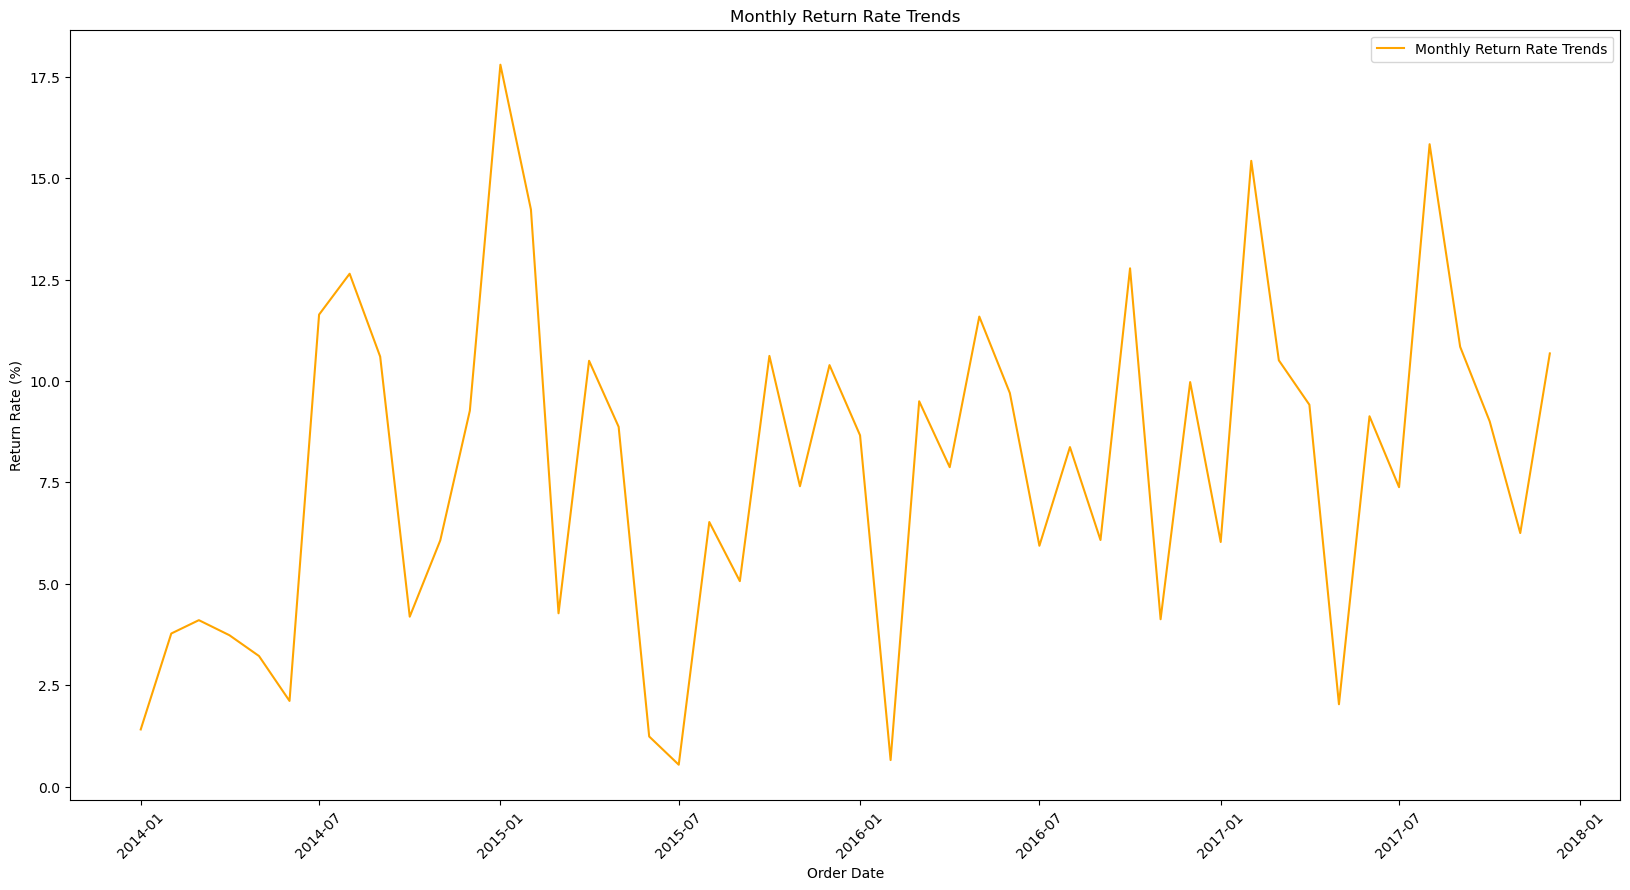

In [31]:
# Analyze return rate (Quantity base)

# return rate monthly 
monthly_data_q = df.groupby(df['Order Date'].dt.to_period('M')).agg(
    total_orders=('Quantity', 'sum'),
    total_returns=('Quantity', lambda x: x[df['Returned'] == 'Yes'].sum())

).reset_index()

# Calculate return Rate
monthly_data_q['return_rate'] = (monthly_data_q['total_returns'] / monthly_data_q['total_orders']) * 100

# Result
print(monthly_data_q)

# Visualization
monthly_data_q['Order Date'] = monthly_data_q['Order Date'].dt.to_timestamp()

plt.figure(figsize=(20, 10))
sns.lineplot(x="Order Date", y="return_rate", data=monthly_data_q, color='orange', label='Monthly Return Rate Trends')
plt.title('Monthly Return Rate Trends')
plt.xlabel('Order Date')
plt.ylabel('Return Rate (%)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

   Order Date  total_order_amount  total_return_amount  return_rate
0     2014-01          14236.8950              38.6600     0.271548
1     2014-02           4519.8920              11.3640     0.251422
2     2014-03          55691.0090            1301.8300     2.337595
3     2014-04          28295.3450             233.9900     0.826956
4     2014-05          23648.2870            1673.9200     7.078399
5     2014-06          34595.1276             963.7200     2.785710
6     2014-07          33946.3930            4261.7640    12.554394
7     2014-08          27909.4685            5112.9080    18.319618
8     2014-09          81777.3508            8183.6020    10.007174
9     2014-10          31453.3930            2328.9620     7.404486
10    2014-11          78628.7167            2239.4240     2.848099
11    2014-12          69545.6205            2869.4040     4.125931
12    2015-01          18174.0756            2042.4380    11.238195
13    2015-02          11951.4110            130

C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HWLEE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


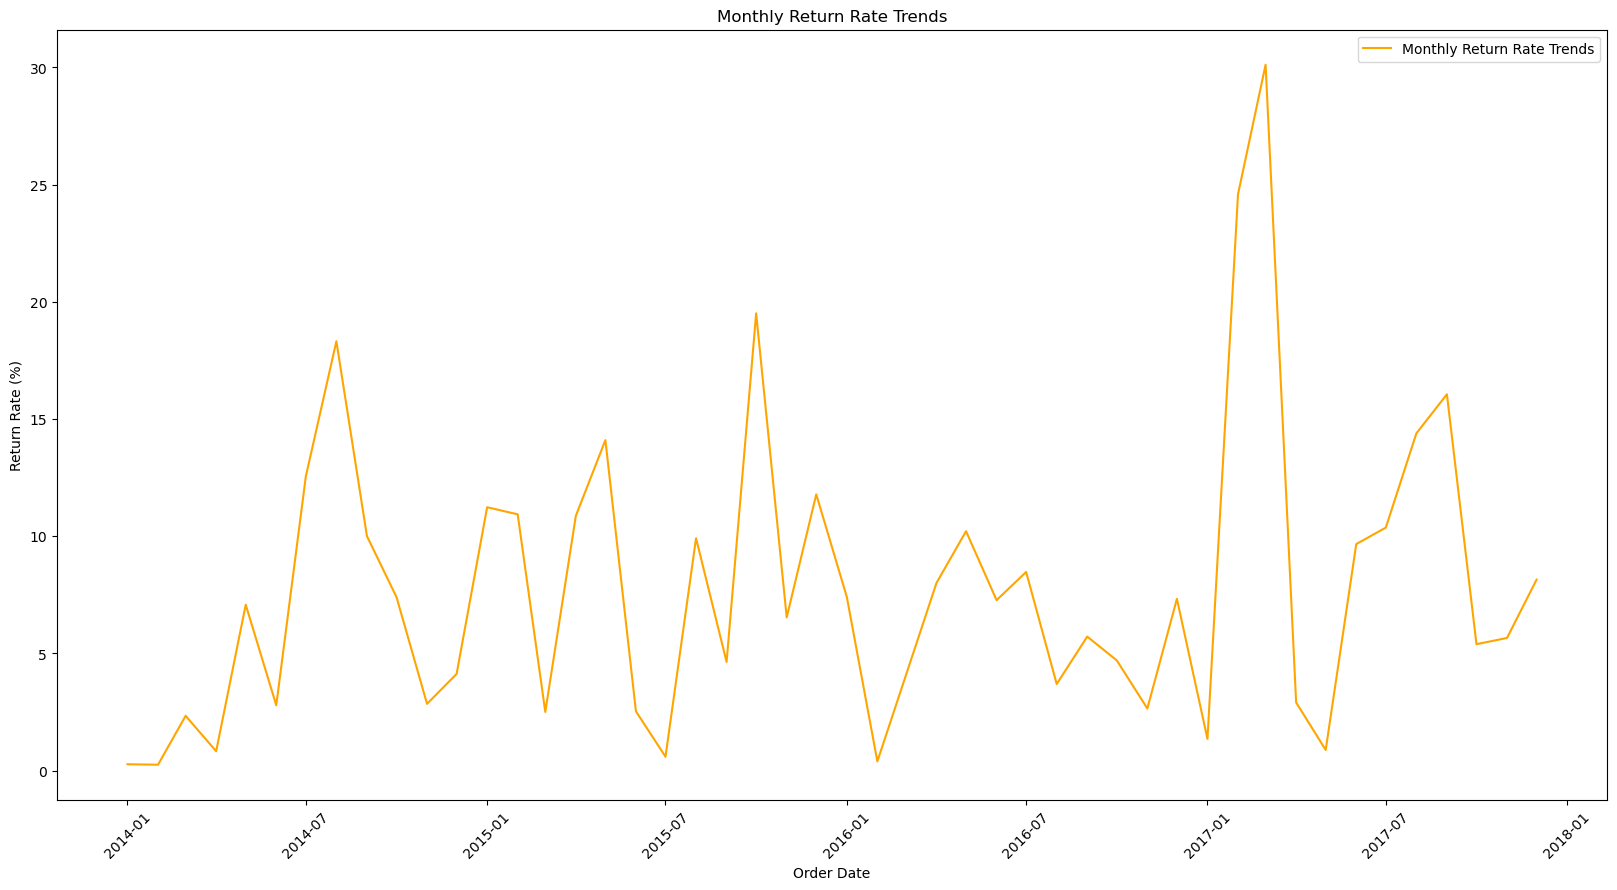

In [32]:
# Analyze return rate (Amount base)

# return rate monthly 
monthly_data_amt = df.groupby(df['Order Date'].dt.to_period('M')).agg(
    total_order_amount=('Sales', 'sum'),
    total_return_amount=('Sales', lambda x: x[df['Returned'] == 'Yes'].sum())
).reset_index()

# Calculate return Rate
monthly_data_amt['return_rate'] = (monthly_data_amt['total_return_amount'] / monthly_data_amt['total_order_amount']) * 100

# Result
print(monthly_data_amt)

# Visualization
monthly_data_amt['Order Date'] = monthly_data_amt['Order Date'].dt.to_timestamp()

plt.figure(figsize=(20, 10))
sns.lineplot(x="Order Date", y="return_rate", data=monthly_data_amt, color='orange', label='Monthly Return Rate Trends')
plt.title('Monthly Return Rate Trends')
plt.xlabel('Order Date')
plt.ylabel('Return Rate (%)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [46]:
# Group by Customer ID and calculate total quantity and total returns
customer_return_rate = df.groupby('Customer ID').agg(
    ttl=('Sales', 'sum'),
    ttr=('Sales', lambda x: x[df['Returned'] == 'Yes'].sum())
).reset_index()

# Calculate return rate for each customer
customer_return_rate['return_rate'] = customer_return_rate['ttr'] / customer_return_rate['ttl']*100

# Display the results
customer_return_rate['return_rate'].mean()
print(f"Return Rate per Customer: {customer_return_rate['return_rate'].mean()}%")

Return Rate: 7.533947236467197%


In [50]:
# Filter the data for the specific customer ID
customer_data = df[df['Customer ID'] == 'RB-19360']

# Calculate total Sales and total returns
ttl2 = customer_data['Sales'].sum()
ttr2 = customer_data[customer_data['Returned'] == 'Yes']['Sales'].sum()

# Calculate return rate
return_rate = ttr2 / ttl2 if ttl2 > 0 else 0

# Display the results
print(f"Return Rate: {return_rate*100}%")


Return Rate: 92.95604206533967%


In [51]:
# Calculate the average return rate per customer (as percentage)
average_return_rate = customer_return_rate['return_rate'].mean()

# Calculate the specific customer's return rate (as percentage)
specific_return_rate = (return_rate * 100)

# Compare the two rates
difference = specific_return_rate - average_return_rate  # Difference in percentage points
ratio = specific_return_rate / average_return_rate if average_return_rate > 0 else None  # Ratio of specific to average

# Display the results
print(f"Average Return Rate per Customer: {average_return_rate}%")
print(f"Specific Customer Return Rate (RB-19360): {specific_return_rate}%")
print(f"Difference: {difference} percentage points")
print(f"Ratio: {ratio} (Specific Customer Rate / Average Rate)")

Average Return Rate per Customer: 7.533947236467197%
Specific Customer Return Rate (RB-19360): 92.95604206533967%
Difference: 85.42209482887247 percentage points
Ratio: 12.338292152538147 (Specific Customer Rate / Average Rate)


Due to price of returned product from Raymond Buch is too expensive, it seems like he returned most of his purchase. To avoid mis-analysis, I will check with quantity base as well.

In [53]:
# Group by Customer ID and calculate total quantity and total returns (in Quantity)
customer_return_rate = df.groupby('Customer ID').agg(
    ttl=('Quantity', 'sum'),
    ttr=('Quantity', lambda x: x[df['Returned'] == 'Yes'].sum())
).reset_index()

# Calculate return rate for each customer as a percentage
customer_return_rate['return_rate'] = (customer_return_rate['ttr'] / customer_return_rate['ttl']) * 100

# Calculate the average return rate across all customers
average_return_rate = customer_return_rate['return_rate'].mean()

# Calculate return rate for the specific customer (Customer ID = 'RB-19360') using Quantity
# Filter the data for the specific customer ID
customer_data = df[df['Customer ID'] == 'RB-19360']

# Calculate total quantity and returned quantity for the specific customer
ttl2 = customer_data['Quantity'].sum()
ttr2 = customer_data[customer_data['Returned'] == 'Yes']['Quantity'].sum()

# Calculate return rate for the specific customer
specific_return_rate = (ttr2 / ttl2) * 100 if ttl2 > 0 else 0

# Compare the two rates
difference = specific_return_rate - average_return_rate  # Difference in percentage points
ratio = specific_return_rate / average_return_rate if average_return_rate > 0 else None  # Ratio of specific to average

# Display the results
print(f"Average Return Rate per Customer: {average_return_rate}%")
print(f"Specific Customer Return Rate (RB-19360): {specific_return_rate}%")
print(f"Difference: {difference} percentage points")
print(f"Ratio: {ratio} (Specific Customer Rate / Average Rate)")

Average Return Rate per Customer: 7.63335169026776%
Specific Customer Return Rate (RB-19360): 12.676056338028168%
Difference: 5.0427046477604085 percentage points
Ratio: 1.6606147407291176 (Specific Customer Rate / Average Rate)


I checked the return rate based on quantity, and while Raymond Buch's return rate is still high, it seems reasonable. Possible reasons could include dissatisfaction with product quality, issues with delivery, or a particular preference that leads to more returns.

Upon comparing the absolute values with the return rate, it can be concluded that the increase in returns in 2017 is not solely attributed to a rise in sales.

*NOTES*
- 1 Specific person returned 3 products on 2017 March 23rd
    - He purchased other products later
    - Ordered with 'First Class' delivery option
    - His return rate is about 12.7% which is higher than average customer's return rate.

- Might have an issue with quality of product or delivery
    -  Need to check customer feedback or product review.